# Background

Links:
- [BayesSearchCV](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html)
- [BayesSearchCV Docs Example](https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from skopt import BayesSearchCV
from skopt.plots import plot_objective, plot_histogram
from time import time

plt.style.use("../style.mplstyle")
%matplotlib inline

In [2]:
data = pd.read_csv("../data/cardio.csv", sep=";", index_col=0)
n_samples = 20000
X, y = data.iloc[:n_samples, :-1].values, data.iloc[:n_samples, -1].values
print(f"Number of records         : {X.shape[0]}")
print(f"Number of features        : {X.shape[1]}")
print(f"Count of positive outcomes: {sum(y)} ({sum(y)/len(y)*100:.1f}%)")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
data.sample(10)

Number of records         : 20000
Number of features        : 11
Count of positive outcomes: 9861 (49.3%)


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
59672,21032,1,166,66.0,110,80,1,1,0,0,1,0
69090,23577,1,168,64.0,120,80,1,1,0,0,0,1
91731,21069,2,176,86.0,120,80,1,1,1,1,1,1
25072,21124,2,170,65.0,140,90,1,1,0,0,1,0
76636,19668,1,158,80.0,110,70,1,1,0,0,1,0
47755,18283,2,170,100.0,120,80,2,1,0,0,1,1
79297,23214,2,173,85.0,150,100,1,1,0,0,1,1
56162,18236,1,168,92.0,200,140,1,1,0,0,1,1
31460,19048,1,159,60.0,140,90,1,3,0,0,1,1


In [3]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)
model = RandomForestClassifier(random_state=42)

## BayesSearchCV

In [4]:
rf_params = {
    "max_depth": (5, 150),
    "min_samples_leaf": (1, 20),
    "criterion": ["gini", "entropy"],  # categorical parameter
}

In [5]:
start = time()

opt = BayesSearchCV(
    model, rf_params, n_iter=32, cv=cv, n_jobs=1, random_state=42, scoring="roc_auc"
)
print(f"Number of iterations: {opt.total_iterations}")  # n_iter * len(rf_params)

best_score, iteration = 0, 0
# callback handler
def on_step(optim_result):
    global best_score
    global iteration
    iteration += 1
    score = opt.best_score_
    if score > best_score:
        best_score = score
        print(f"Best score (iteration): {best_score:.4f} ({iteration})")
    elif iteration % 10 == 0:
        print(f"Iteration {iteration}...")


opt.fit(X_train, y_train, callback=on_step)
end = time()
print(f"\nRun time: {(end - start) / 60:.1f} minutes")
print(f"Best score: {opt.best_score_:.4f}")
print(f"Test score: {opt.score(X_test, y_test):.4f}")
print(f"Best parameters: {opt.best_params_}")

Number of iterations: 96
Best score (iteration): 0.7982 (1)
Best score (iteration): 0.7983 (9)
Iteration 10...
Iteration 20...
Iteration 30...

Run time: 3.5 minutes
Best score: 0.7983
Test score: 0.7933
Best parameters: OrderedDict([('criterion', 'gini'), ('max_depth', 107), ('min_samples_leaf', 18)])


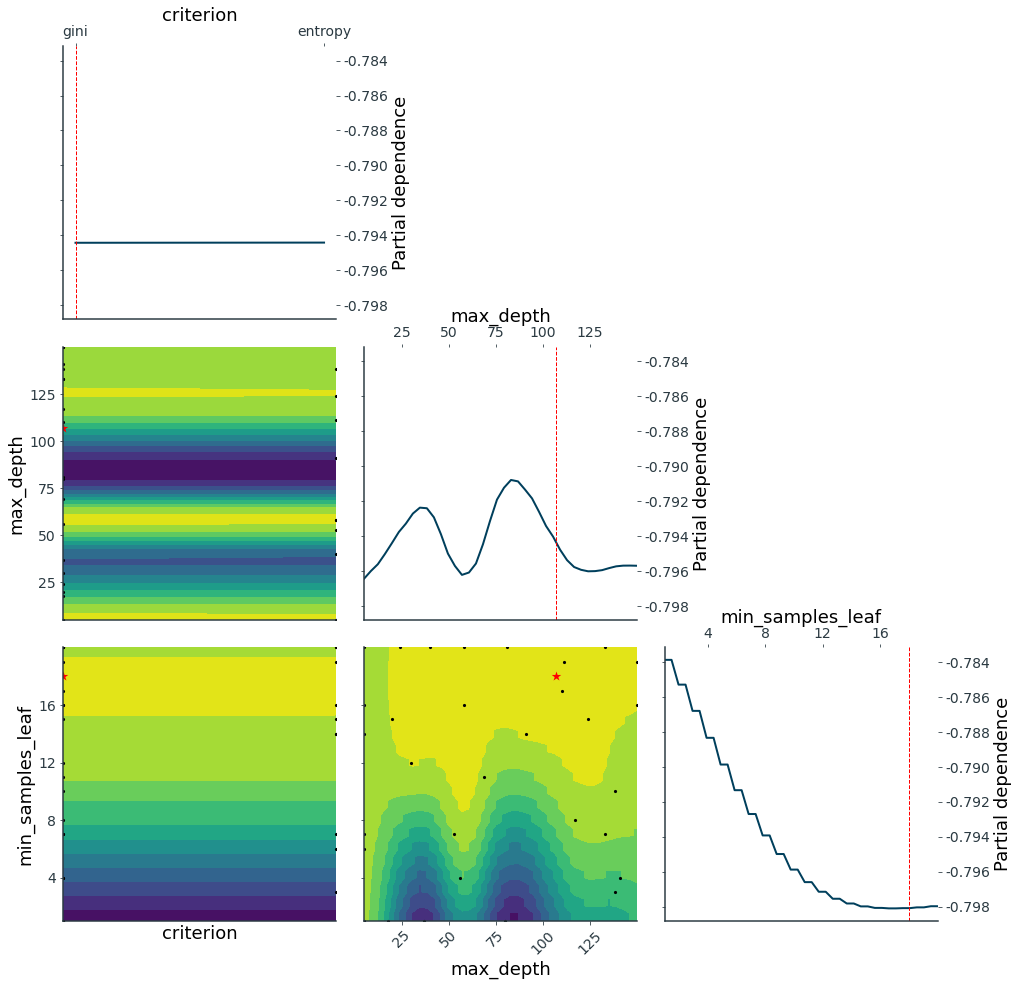

In [6]:
_ = plot_objective(
    opt.optimizer_results_[0],
    dimensions=["criterion", "max_depth", "min_samples_leaf"],
    n_minimum_search=int(1e8),
    size=4.5,
)

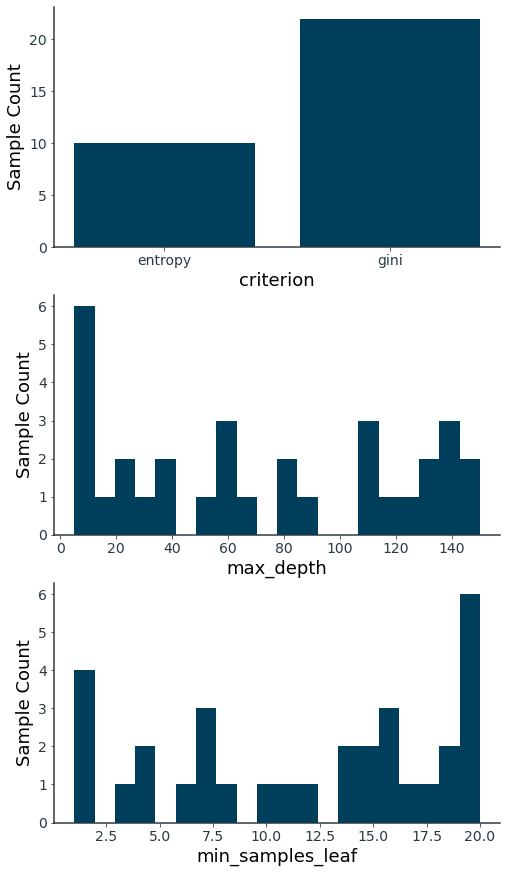

In [7]:
fig, ax = plt.subplots(len(rf_params), 1, figsize=(8, 5*len(rf_params)))
for i in range(len(rf_params)):
    plot_histogram(opt.optimizer_results_[0], i, ax=ax[i])

## RandomizedSearchCV

In [8]:
start = time()

opt_rcv = RandomizedSearchCV(
    model,
    rf_params,
    n_iter=96,
    cv=cv,
    n_jobs=1,
    random_state=42,
    scoring="roc_auc"
)
opt_rcv.fit(X_train, y_train)
end = time()
print(f"\nRun time: {(end - start) / 60:.1f} minutes")
print(f"Best score: {opt_rcv.best_score_:.4f}")
print(f"Test score: {opt_rcv.score(X_test, y_test):.4f}")
print(f"Best parameters: {opt_rcv.best_params_}")

C:\Users\aidan\Anaconda3\envs\sandbox\lib\site-packages\sklearn\model_selection\_search.py:282: UserWarning: The total space of parameters 8 is smaller than n_iter=96. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)



Run time: 0.7 minutes
Best score: 0.7981
Test score: 0.7934
Best parameters: {'min_samples_leaf': 20, 'max_depth': 150, 'criterion': 'gini'}


## GridSearchCV

In [9]:
rf_params_grid = {
    "max_depth": [5, 12, 25, 50, 100, 150],
    "min_samples_leaf": [1, 4, 10, 20],
    "criterion": ["gini", "entropy"],  # categorical parameter
}

In [10]:
start = time()

opt_gcv = GridSearchCV(
    model,
    rf_params_grid,
    cv=cv,
    n_jobs=1,
    scoring="roc_auc"
)
opt_gcv.fit(X_train, y_train)
end = time()
print(f"\nRun time: {(end - start) / 60:.1f} minutes")
print(f"Best score: {opt_gcv.best_score_:.4f}")
print(f"Test score: {opt_gcv.score(X_test, y_test):.4f}")
print(f"Best parameters: {opt_gcv.best_params_}")


Run time: 4.9 minutes
Best score: 0.7986
Test score: 0.7936
Best parameters: {'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 20}
